In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

from tqdm.notebook import trange

%matplotlib inline
%load_ext autoreload
%autoreload 2

# GPR tutorial

## generate training dataset

$$ y = sin(2\pi x) + \epsilon $$
$$\epsilon \sim N(0, 0.04)$$

Text(0, 0.5, 'y=f(x)')

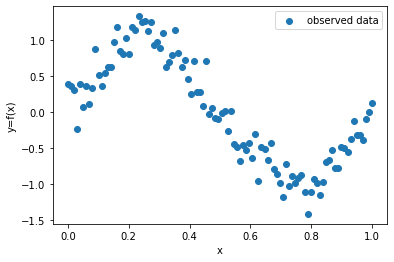

In [2]:
torch.manual_seed(42)

x_train = torch.linspace(0, 1, 100)
y_train = (torch.sin(x_train * 2 * math.pi) +
           torch.randn(x_train.size()) * 0.2)
plt.scatter(x_train, y_train, label = "observed data")
plt.legend(loc = 'upper right')
plt.xlabel('x')
plt.ylabel('y=f(x)')

## show parametric approach

Text(0, 0.5, 'y=f(x)')

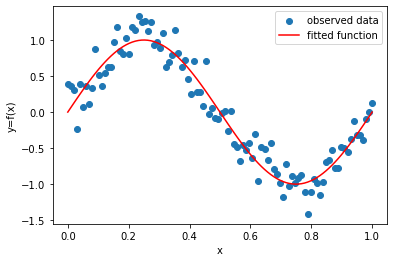

In [3]:
plt.scatter(x_train, y_train, label = "observed data")
plt.plot(x_train, torch.sin(x_train * 2 * math.pi),
         label = "fitted function", color='red')
plt.legend(loc = 'upper right')
plt.xlabel('x')
plt.ylabel('y=f(x)')

## define GPR model

1. A **GP Model** (gpytorch.models.ExactGP) - This handles most of the inference.
2. A **Likelihood** (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.
3. A **Mean** - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)
4. A **Kernel** - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).
5. A **MultivariateNormal Distribution** (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.

In [4]:
class TutorialGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(TutorialGPModel, self).__init__(x_train, y_train, likelihood)

        self.mean = gpytorch.means.ConstantMean()
        self.cov  = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        """
        Evaluate the mean and kernel function at the point x
        :param x:
        :return: multivariate normal
        """
        mean_x = self.mean(x)
        cov_x  = self.cov (x)

        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = TutorialGPModel(
    x_train,
    y_train,
    likelihood
)

## train the model

The training loop mainly consists of the following steps:

1. Setting all the parameter gradients to zero
2. Calling the model and computing the loss
3. Calling backward on the loss to fill in gradients
4. Taking a step on the optimizer

In [6]:
# put the model into training mode
model.train()
likelihood.train()

# use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# define negative marginal log-likelihood as the loss function
lf = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# number of training iterations
n_iter = 50

In [7]:
losses = []

# training loop
for i in trange(n_iter):
    # 1. set gradients to zero
    optimizer.zero_grad()

    # 2. call the model and compute the loss
    output = model(x_train)
    loss = -lf(output, y_train)

    # 3. backprop gradients
    loss.backward()

    losses.append(loss.item())

    optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

/home/olga/miniconda3/envs/jupyter/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755883846/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Text(0.5, 1.0, 'Training process & loss')

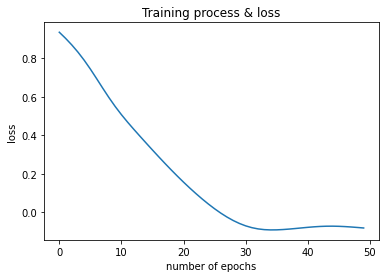

In [8]:
# plot the loss
plt.plot(losses)
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Training process & loss")

## make predictions with model

In [9]:
# test data
x_test = torch.linspace(0, 5, 50)

# set the model to evaluation mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_test))

## Plot the model fit

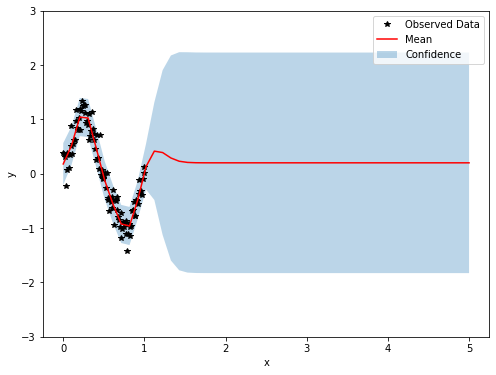

In [10]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_xlabel('x')
    ax.set_ylabel('y')

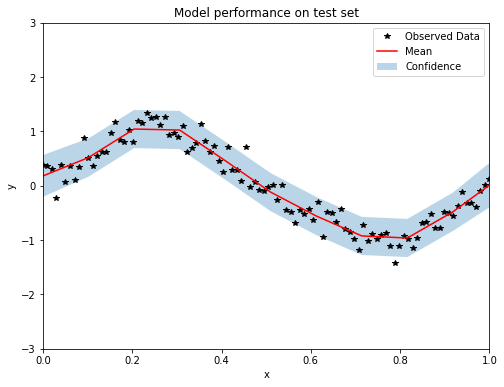

In [11]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    ax.set_ylim([-3, 3])
    ax.set_xlim([0, 1])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Model performance on test set')